In [2]:
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import format_time

In [3]:
def generate_data(size):
    data = np.zeros((size, size), dtype="float32")
    data[:, 0] = np.sin(np.pi * np.arange(size) / size)
    return data

def time_jacobi(data, jacobi_solver):    
    jacobi_solver(data, max_diff=1e-5, max_iter=1)  # warmup    
    start = timeit.default_timer()
    iters = jacobi_solver(data, max_diff=1e-5, max_iter=1000)
    end = timeit.default_timer()
    time_per_iter = (end - start) / iters    
    return time_per_iter

def plot_solution(data):
    M, N = data.shape
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.w_xaxis.set_pane_color((0.5, 0.5, 0.5, 0.5))
    x, y = np.meshgrid(np.linspace(0, 1, M), np.linspace(0, 1, N))
    ax.plot_surface(x, y, data, cmap="hot")

In [23]:
%%writefile jacobi_parallel.pyx

# distutils: language=c++
# cython: cdivision=True

from libcpp.execution cimport par, seq
from libcpp.algorithm cimport any_of, for_each, swap, copy
from libcpp.vector cimport vector
from libcpp.functional cimport function
from libcpp cimport bool, float
from libc.math cimport fabs

cdef cppclass avg:
    float *T1
    float *T2
    int M, N
    
    __init__(float* T1, float *T2, int M, int N):
        this.T1, this.T2, this.M, this.N = T1, T2, M, N

    void call "operator()"(int i):
        if (i % this.N != 0 and i % this.N != this.N-1):
            this.T2[i] = 0.25 * (
                this.T1[i-this.N] + this.T1[i+this.N] + this.T1[i-1] + this.T1[i+1]
            )

cdef cppclass converged:
    float *T1
    float *T2
    float max_diff
    
    __init__(float* T1, float *T2, float max_diff):
        this.T1, this.T2, this.max_diff = T1, T2, max_diff

    bool call "operator()"(int i):
        return fabs(this.T2[i] - this.T1[i]) > this.max_diff

def jacobi_solver(float[:, :] data, float max_diff, int max_iter=10_000):
    M, N  = data.shape[0], data.shape[1]
    
    cdef vector[float] temp
    temp.resize(M*N)
    
    cdef vector[int] indices = range(N+1, (M-1)*N-1)
    
    copy(&data[0, 0], &data[-1, -1], temp.begin())
    
    cdef int iterations = 0
    cdef float* T1 = &data[0, 0]
    cdef float* T2 = temp.data()

    keep_going = True
    while keep_going and iterations < max_iter:
        iterations += 1
        for_each(par, indices.begin(), indices.end(), avg(T1, T2, M, N))
        keep_going = any_of(par, indices.begin(), indices.end(), converged(T1, T2, max_diff))
        swap(T1, T2)

    if (T2 == &data[0, 0]):
        copy(temp.begin(), temp.end(), &data[0, 0])

    return iterations


Overwriting jacobi_parallel.pyx


In [24]:
!python setup.py build_ext --inplace

Compiling jacobi_parallel.pyx because it changed.
[1/1] Cythonizing jacobi_parallel.pyx
/home/ashwin/workspace/github/cython/cython/Cython/Compiler/Main.py:344: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/ashwin/workspace/github/shwina/stdpar-cython/jacobi_parallel.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'jacobi_parallel' extension
gcc -pthread -B /home/ashwin/miniconda3/envs/cython-dev/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/ashwin/miniconda3/envs/cython-dev/include/python3.8 -c jacobi_parallel.cpp -o build/temp.linux-x86_64-3.8/jacobi_parallel.o -std=c++17
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
g++ -pthread -shared -B /home/ashwin/miniconda3/envs/cython-dev/compiler_compat -L/home/ashwin/miniconda3/envs/cython-dev/lib -Wl,-

In [227]:
sizes = [100, 250, 500, 750, 1000]

In [228]:
from jacobi_parallel import jacobi_solver as jacobi_solver

jacobi_parallel_times = pd.Series(
    [time_jacobi_iteration(generate_data(size), jacobi_solver) for size in sizes],
    index=sizes,
    name="Jacobi solver (parallel, CPU)"
)
jacobi_parallel_times.map(format_time)

100      24.24555488745429 µs
250     63.506904896348715 µs
500     207.51881506294012 µs
750      475.6622273474932 µs
1000     881.7408797331155 µs
Name: Jacobi solver (parallel, CPU), dtype: object

In [25]:
%%writefile jacobi_parallel.pyx

# distutils: language=c++
# cython: cdivision=True

from libcpp.execution cimport par, seq
from libcpp.algorithm cimport any_of, for_each, swap, copy
from libcpp.vector cimport vector
from libcpp.functional cimport function
from libcpp cimport bool, float
from libc.math cimport fabs


cdef cppclass avg:
    float *T1
    float *T2
    int M, N

    __init__(float* fro, float *to, int M, int N):
        this.T1, this.T2, this.M, this.N = fro, to, M, N

    void call "operator()"(int i):
        if (i % N != 0 and i % N != N-1):
            this.T2[i] = 0.25 * (
                this.T1[i-this.N] + this.T1[i+this.N] + this.T1[i-1] + this.T1[i+1]
            )

cdef cppclass converged:
    float *T1
    float *T2
    float max_diff
    
    __init__(float* fro, float *to, float max_diff):
        this.T1, this.T2, this.max_diff = fro, to, max_diff

    bool call "operator()"(int i):
        return fabs(this.T2[i] - this.T1[i]) > this.max_diff

def jacobi_solver(float[:, :] data, float max_diff, int max_iter=10_000):
    M, N  = data.shape[0], data.shape[1]
    
    cdef vector[float] local
    cdef vector[float] temp
    
    local.resize(M*N)
    temp.resize(M*N)
    
    cdef vector[int] indices = range(N+1, (M-1)*N-1)
    
    copy(&data[0, 0], &data[-1, -1], local.begin())
    copy(par, local.begin(), local.end(), temp.begin())
    
    cdef int iterations = 0
    cdef float* T1 = local.data()
    cdef float* T2 = temp.data()

    keep_going = True
    while keep_going and iterations < max_iter:
        iterations += 1
        for_each(par, indices.begin(), indices.end(), avg(T1, T2, M, N))
        keep_going = any_of(par, indices.begin(), indices.end(), converged(T1, T2, max_diff))
        swap(T1, T2)

    if (T2 == &data[0, 0]):
        copy(temp.begin(), temp.end(), &data[0, 0])

    return iterations


Overwriting jacobi_parallel.pyx


In [26]:
!CC=/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/bin/nvc++ python setup.py build_ext --inplace

Compiling jacobi_parallel.pyx because it changed.
[1/1] Cythonizing jacobi_parallel.pyx
/home/ashwin/workspace/github/cython/cython/Cython/Compiler/Main.py:344: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/ashwin/workspace/github/shwina/stdpar-cython/jacobi_parallel.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'jacobi_parallel' extension
/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/bin/nvc++ -fPIC -stdpar -gpu=nordc -std=c++17 -I/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/include-stdpar -I/home/ashwin/miniconda3/envs/cython-dev/include/python3.8 -c jacobi_parallel.cpp -o build/temp.linux-x86_64-3.8/jacobi_parallel.o -std=c++17
"jacobi_parallel.cpp", line 18934: warning: variable "__pyx_lineno" was set but
          never used
    int __pyx_lineno = 0;
        ^

"jacobi_parallel.cpp", line 18935: warning: variable "__pyx_filename" was set
   

/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/bin/nvc++ -shared -stdpar build/temp.linux-x86_64-3.8/jacobi_parallel.o -L/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/lib -Wl,-R/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/lib -o build/lib.linux-x86_64-3.8/jacobi_parallel.cpython-38-x86_64-linux-gnu.so
copying build/lib.linux-x86_64-3.8/cppsort_parallel.cpython-38-x86_64-linux-gnu.so -> 
copying build/lib.linux-x86_64-3.8/cppsort_serial.cpython-38-x86_64-linux-gnu.so -> 
copying build/lib.linux-x86_64-3.8/cppsort_stdpar.cpython-38-x86_64-linux-gnu.so -> 
copying build/lib.linux-x86_64-3.8/jacobi_parallel.cpython-38-x86_64-linux-gnu.so -> 


In [230]:
from jacobi_stdpar import jacobi_solver as jacobi_solver

jacobi_stdpar_times = pd.Series(
    [time_jacobi_iteration(generate_data(size), jacobi_solver) for size in sizes],
    index=sizes,
    name="Jacobi solver (stdpar)"
)
jacobi_stdpar_times.map(format_time)

100     49.342860160100514 µs
250      42.72337444126607 µs
500     53.473767917603254 µs
750      96.38186441734433 µs
1000    136.74995154142383 µs
Name: Jacobi solver (stdpar), dtype: object

In [231]:
speedups = jacobi_parallel_times / jacobi_stdpar_times

<AxesSubplot:xlabel='Input array size', ylabel='Speedup'>

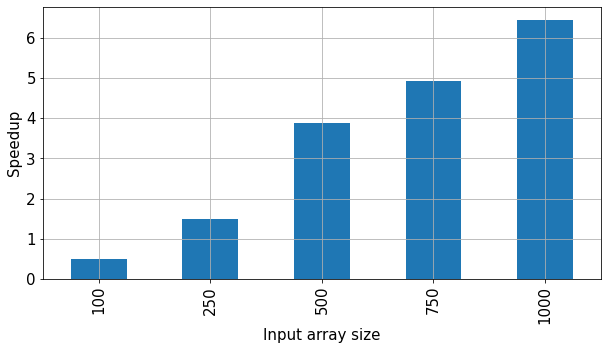

In [232]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})
speedups.plot(
    kind="bar", 
    xlabel="Input array size", 
    ylabel="Speedup", 
    figsize=(10, 5),
    grid=True
)

